In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense,Embedding,Input,Dropout,Conv1D
from tensorflow.keras.layers import SpatialDropout1D, Flatten,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import plot_model

2023-10-29 16:43:02.871544: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-29 16:43:03.006826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-29 16:43:03.547650: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
# Load your Numpy arrays
# FS_labels = np.load('./data/FS_labels.npy', allow_pickle=True)
test_df = pd.read_csv('./data/tc_test.csv')
train_df = pd.read_csv('./data/tc_train.csv')

In [24]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,description
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,unknown unknown he matches this background col...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man unknown unknown really not trying to e...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,unknown unknown more i can't make any real sug...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you unknown sir unknown are my hero unknown an...


In [10]:
# Create embedding index from file in .txt format. First line contains 
# dictionary size and embedding dim. Fields are space separated
def get_embeddings(file_name):
    embeddings_index = {}
    with open(file_name, encoding="utf8") as f:
        for line in f:
            values = line.rstrip().split(' ')
            if len(values) > 2:
                embeddings_index[values[0]] = np.asarray(values[1:], dtype="float32")
    return embeddings_index
embeddings_path = "./crawl-300d-2M.vec"
embeddings_index = get_embeddings(embeddings_path)

In [11]:
import string
trans_table = str.maketrans({key: ' ' for key in string.digits + '\r\n' +
                             string.punctuation.replace("\'",'')})
def preprocess(text):
    return ' '.join(text.lower().translate(trans_table).split(' '))

In [12]:
train_df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [13]:
### PROCESS TRAINING DATA

from sklearn.feature_extraction.text import CountVectorizer

UNKNOWN_PROXY = 'unknown'
MIN_WORD_OCCURRENCE = 5

train_df['description'] = train_df.comment_text.apply(preprocess)
print("Creating the vocabulary of words occurred more than", MIN_WORD_OCCURRENCE)

vectorizer = CountVectorizer(lowercase=False, token_pattern="\S+", 
                             min_df=MIN_WORD_OCCURRENCE)
vectorizer.fit(train_df.description)

top_words = set(vectorizer.vocabulary_.keys())
top_words.add(UNKNOWN_PROXY)
print(len(top_words),'top words')


### APPLY TO TEST DATA
test_df['description'] = test_df.comment_text.apply(preprocess)

Creating the vocabulary of words occurred more than 5
45259 top words


In [14]:
print('First 10 out of "top_words": \n',list(top_words)[:10])
print('\nIs "unknown" in top_words? \n','unknown' in top_words)

First 10 out of "top_words": 
 ['continues', 'love', 'coated', 'foundational', 'bestowed', 'mobility', "wikinews'", 'egyptians', 'fitting', 'novel']

Is "unknown" in top_words? 
 True


In [15]:
def filter_unknown(text, vocabulary, proxy):
    return ' '. \
join([w if w in vocabulary else proxy for w in text.split(' ')])

In [16]:
train_df['description'] = train_df.description.apply(filter_unknown,
                args=(set(embeddings_index.keys() & top_words), \
                      UNKNOWN_PROXY))

test_df['description'] = test_df.description.apply(filter_unknown,
                args=(set(embeddings_index.keys() & top_words), \
                      UNKNOWN_PROXY))

In [17]:
tokenizer = Tokenizer(filters="")
tokenizer.fit_on_texts(train_df.description)
print(tokenizer)

In [18]:
word_index = tokenizer.word_index
print(len(word_index))
list(word_index.items())[:16]

40185


[('unknown', 1),
 ('the', 2),
 ('to', 3),
 ('of', 4),
 ('and', 5),
 ('a', 6),
 ('you', 7),
 ('i', 8),
 ('is', 9),
 ('that', 10),
 ('in', 11),
 ('it', 12),
 ('for', 13),
 ('this', 14),
 ('not', 15),
 ('on', 16)]

In [19]:
MAX_SEQUENCE_LENGTH = 50
seq = tokenizer.texts_to_sequences(train_df.description)
data = pad_sequences(seq,maxlen=MAX_SEQUENCE_LENGTH,padding='post',
                     truncating='post')
with open('./text_data.pkl','wb') as f: pickle.dump(data, f, -1)

seq_test = tokenizer.texts_to_sequences(test_df.description)
data_test = pad_sequences(seq_test,maxlen=MAX_SEQUENCE_LENGTH,padding='post', truncating='post')
with open('./text_test_data.pkl','wb') as f: pickle.dump(data, f, -1)

print('\nFirst 2 sequences in `seq`: ',seq[:2])
print('\nShape of `data`: ',data.shape)
print('\nFirst prepared text in `data`:',data[0])


First 2 sequences in `seq`:  [[668, 77, 2, 133, 130, 176, 31, 658, 4322, 10972, 1109, 85, 347, 1, 52, 1, 12090, 1, 51, 6172, 16, 60, 2522, 147, 8, 2744, 34, 116, 1179, 15205, 2412, 1, 5, 48, 61, 245, 2, 357, 32, 2, 42, 28, 142, 1, 3422, 89, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 53, 2714, 14, 463, 3572, 1, 4414, 2647, 22, 1, 93, 1, 1, 1, 42, 1, 1, 1, 1, 1, 1, 1, 1, 953, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 195, 1]]

Shape of `data`:  (223549, 50)

First prepared text in `data`: [  668    77     2   133   130   176    31   658  4322 10972  1109    85
   347     1    52     1 12090     1    51  6172    16    60  2522   147
     8  2744    34   116  1179 15205  2412     1     5    48    61   245
     2   357    32     2    42    28   142     1  3422    89     1     1
     1     1]


In [35]:
mlist=['word_1','word_2','word_3']
moveIter=iter(mlist)
print(next(moveIter,'enough'))
print(next(moveIter,'enough'))
print(next(moveIter,'enough'))
print(next(moveIter,'enough'))
print(next(moveIter,'enough'))

word_1
word_2
word_3
enough
enough


In [20]:
embeddings_dim = len(next(iter(embeddings_index.values())))
embeddings_dim

300

In [21]:
# Create embedding matrix
def get_embedding_matrix(word_index,embeddings_index):
    nb_words = len(word_index) + 1 # +1 since min(word_index.values())=1
    embedding_matrix = np.zeros((nb_words,embeddings_dim))
    unknown = 0
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is None: unknown += 1
        else: embedding_matrix[i] = embedding_vector
    return embedding_matrix, unknown

In [22]:
# Create embedding_layer and save it.
def make_save_emb_layer(word_index,embeddings_index,layer_file_name):
    embedding_matrix,unknown = get_embedding_matrix(word_index,embeddings_index)
    embedding_layer = Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],
                                weights=[embedding_matrix],trainable=False)
    with open(layer_file_name,'wb') as f: 
        pickle.dump(embedding_layer, f, -1)
    return unknown

EMBEDDING_LAYER_FILE = './text_embed_layer.pkl'
print(make_save_emb_layer(word_index,embeddings_index,EMBEDDING_LAYER_FILE),
      'unknown words')

0 unknown words


In [23]:
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate

def get_more_complex_model():
    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embedding_layer(input_layer)
    x = SpatialDropout1D(0.5)(x)
    
    # Stack multiple LSTM layers
    x = LSTM(50, return_sequences=True)(x)
    x = LSTM(50, return_sequences=True)(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    
    x = BatchNormalization()(conc)
    x = Dropout(0.5)(x)  # Increased dropout rate
    
    # Multiple dense layers
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(50, activation="relu")(x)
    
    output_layer = Dense(6, activation="sigmoid")(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss="binary_crossentropy", optimizer='RMSprop')  # Changed optimizer
    return model


In [25]:
data.shape

(180000, 50)

In [26]:
train_df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'description'],
      dtype='object')

In [28]:
labels_array = train_df[['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']].values

with open(EMBEDDING_LAYER_FILE, 'rb') as f: 
    embedding_layer = pickle.load(f)

with open('./text_data.pkl', 'rb') as f: 
    data = pickle.load(f)

# Removed stratify parameter for a random split
X_train, X_test, y_train, y_test = train_test_split(data, labels_array, test_size=0.2, random_state=0)

In [29]:
best_model_path = 'best_model_WOW.h5'
BATCH_SIZE = 512

early_stopping = EarlyStopping(patience=2)
model_checkpoint = ModelCheckpoint(best_model_path,
                                   save_best_only=True, save_weights_only=True)
model = get_more_complex_model()
print(model.summary())
plot_model(model, to_file='wine_reviews.png',show_shapes=True,show_layer_names=True)

2023-10-29 17:04:13.024928: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-29 17:04:13.079948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-29 17:04:13.080182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 300)      12055800    ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 50, 300)     0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 lstm (LSTM)                    (None, 50, 50)       70200       ['spatial_dropout1d[0][0]']  

2023-10-29 17:04:13.905329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-29 17:04:13.906237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-29 17:04:13.906741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [30]:
hist = model.fit(X_train, y_train,validation_data=(X_test, y_test),
                 epochs=50, batch_size=BATCH_SIZE, shuffle=True, verbose=2,
                 callbacks=[model_checkpoint])
model.load_weights(best_model_path)
test_pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
print('validation AUC',roc_auc_score(y_test, test_pred))

Epoch 1/50


2023-10-29 17:04:18.920994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-29 17:04:18.921969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-29 17:04:18.922550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

350/350 - 7s - loss: 0.1134 - val_loss: 0.0887 - 7s/epoch - 19ms/step
Epoch 2/50
350/350 - 4s - loss: 0.0731 - val_loss: 0.0690 - 4s/epoch - 11ms/step
Epoch 3/50
350/350 - 4s - loss: 0.0684 - val_loss: 0.0593 - 4s/epoch - 11ms/step
Epoch 4/50
350/350 - 4s - loss: 0.0661 - val_loss: 0.0601 - 4s/epoch - 11ms/step
Epoch 5/50
350/350 - 4s - loss: 0.0646 - val_loss: 0.0587 - 4s/epoch - 11ms/step
Epoch 6/50
350/350 - 4s - loss: 0.0635 - val_loss: 0.0584 - 4s/epoch - 11ms/step
Epoch 7/50
350/350 - 4s - loss: 0.0625 - val_loss: 0.0601 - 4s/epoch - 11ms/step
Epoch 8/50
350/350 - 4s - loss: 0.0615 - val_loss: 0.0577 - 4s/epoch - 11ms/step
Epoch 9/50
350/350 - 4s - loss: 0.0613 - val_loss: 0.0580 - 4s/epoch - 11ms/step
Epoch 10/50
350/350 - 4s - loss: 0.0602 - val_loss: 0.0571 - 4s/epoch - 11ms/step
Epoch 11/50
350/350 - 4s - loss: 0.0598 - val_loss: 0.0570 - 4s/epoch - 11ms/step
Epoch 12/50
350/350 - 4s - loss: 0.0592 - val_loss: 0.0582 - 4s/epoch - 11ms/step
Epoch 13/50
350/350 - 4s - loss: 0.0

2023-10-29 17:07:32.701361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-29 17:07:32.702151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-29 17:07:32.702663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

validation AUC 0.9800054774770003


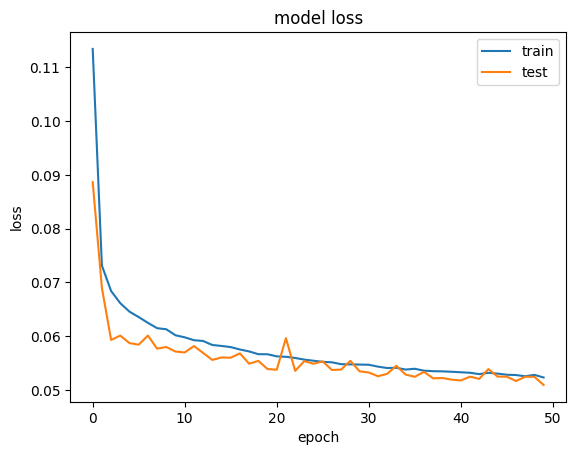

In [31]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

### Get submission predictions

In [36]:
test_pred = model.predict(data_test, batch_size=BATCH_SIZE, verbose=0)

In [41]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
submission_df = pd.DataFrame(data=test_pred, columns=labels)
submission_df['id'] = test_df.id
submission_df = submission_df[['id'] + labels]

In [43]:
submission_df

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.970390,2.107197e-01,0.821872,1.822438e-01,0.715373,0.225054
1,0000247867823ef7,0.000740,7.502666e-08,0.000179,4.910801e-07,0.000075,0.000004
2,00013b17ad220c46,0.003903,2.965001e-06,0.001128,1.247967e-05,0.000578,0.000046
3,00017563c3f7919a,0.000552,4.648180e-08,0.000152,4.068810e-07,0.000062,0.000003
4,00017695ad8997eb,0.007073,5.355912e-06,0.001192,3.229658e-05,0.000742,0.000035
...,...,...,...,...,...,...,...
89181,fffcd0960ee309b5,0.370110,4.770738e-04,0.114075,1.091621e-04,0.057715,0.000304
89182,fffd7a9a6eb32c16,0.028361,1.058479e-04,0.008338,3.143474e-04,0.003883,0.000585
89183,fffda9e8d6fafa9e,0.008304,1.413632e-05,0.003278,3.155952e-05,0.001639,0.000167
89184,fffe8f1340a79fc2,0.006108,8.129275e-06,0.002579,1.512204e-05,0.001182,0.000149


In [45]:
# Round predictions to the nearest integer (0 or 1)

# Save the rounded predictions to a CSV file
submission_df.to_csv('submission.csv', index=False)

# ('submission.csv', submission_df, fmt='%d', delimiter=',')

In [34]:
len(test_pred)

89186

In [35]:
len(test_df.id)

89186

In [1]:
from collections import deque

# Define the graph as an adjacency list
graph = {
    'A': ['B', 'C'],
    'B': ['A', 'D', 'E'],
    'C': ['A', 'F'],
    'D': ['B'],
    'E': ['B', 'F'],
    'F': ['C', 'E']
}

def is_goal(state, end):
    return state == end

def available_successors(node):
    # Directly access the adjacency list using the node
    if node in graph:
        return graph[node]
    return []

def bfs(start, end):
    visited = set()
    queue = deque([(start, [start])])  # We also keep track of the path to each state

    while queue:
        (node, path) = queue.popleft()

        if node in visited:
            continue

        visited.add(node)

        if is_goal(node, end):
            return path  # Return the path to the goal

        for neighbor in available_successors(node):
            if neighbor not in visited:
                queue.append((neighbor, path + [neighbor]))

    return None  # No path exists between start and end

# Example usage:
start_node = 'A'
end_node = 'F'
path = bfs(start_node, end_node)
print(f"Shortest path from {start_node} to {end_node}: {path}")


Shortest path from A to F: ['A', 'C', 'F']
